## import

In [1]:
#importing libraries & packages
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import datetime
import re
import pprint
pp = pprint.PrettyPrinter(indent=4)
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

#display multiple outputs from cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# machine learning
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.base import clone 

#from sklearn.utils import compute_class_weight

Using TensorFlow backend.


In [3]:
# import Animal Control Incidents df
df = pd.read_csv('Animal_Control_Incidents.csv')

## functions

In [4]:
# regex for letters and '/' only, unless pattern reassigned
def remove_numpunc(list, pattern='[^A-Za-z,]+'):
    """regex to apply to list/df column --default: to include only letters and '/' """
    pattern = pattern
    #pattern = '[^A-Za-z_]+'
    if pattern =='[^A-Za-z,]+':
        list = [re.sub(pattern, ',', i) for i in list] 
    if pattern == '[^A-Za-z_]+':
        list = [re.sub(pattern, '', i) for i in list]
    if pattern == '[^A-Za-z/]+':
        list = [re.sub(pattern, '/', i) for i in list]
    if pattern == '[^0-9]+':
        list = [re.sub(pattern, '', i) for i in list]
    return list

In [5]:
# str type, eliminate misplaced whitespace, lower casing, replacing blankspace with '_'
def clean_str(col):
    
    df[col] = df[col].astype(str, skipna=True)
    df[col] = df[col].str.strip()
    df[col] = df[col].apply(lambda x: x.replace(' ', '_'))
    df[col] = df[col].str.lower()

In [7]:
# plotting counts of timedate data 
def plot_dtcount(td_df, col, limitsy = None, limitsx= None, overlap = True, labels = None, alpha=0.3, size=6):
    """Plots incident count(y) with timeframe as x axis:
    
        td_df = dataframe with date/time
        col = date/time column(s) of dataframe to plot counts
        limitsy= (y,y), limitsx= (x,x) can be adjusted
         -, helful if wanting to exclude extreme outliers -
         overlap= boolean(if looping and want plots seperately plotted, set to False)
         labels= str or list of str for legend
         """
    
    td_df[col] = td_df[col].dropna()
    time_c = td_df.groupby([col])[col].count()
    
    if limitsy:
        plt.ylim(limitsy)
        
    if limitsx:
        plt.xlim(limitsx)

    if labels:
        plt.legend(
        (labels),
        loc='upper right'
        ,fontsize= 12)
    
    plt.scatter(time_c.index, time_c.values, s= size, alpha=alpha, label=col)
    if not overlap:
        plt.xlabel(col)
        plt.show();

In [8]:
# pretty blue/green seaborn correlation plot for categorical data
def corr_plot(data, minv=-.3, maxv=.3, dummy=True):
    """pretty blue/green seaborn correlation plot:
    
    data= dataframe(will include all columns)
    minv = -float, maxv = float  --adjust closer to 0 for more contrast, closer to -1/1 for less
    dummy = False if df is all numerical. when True:function will only dummy categorical features
    """
    
    if dummy:
        # dummy categorical features
        col_list = list(data.select_dtypes(include=['object']).columns)

        # create dummies for categorical features
        data = pd.DataFrame(pd.get_dummies(data=data,columns=col_list
                       , prefix=col_list))
    sns.set(style="white")
    corr = data.corr()

    # mask the size of covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(10, 10))

    sns.heatmap(corr, mask=mask
                ,annot=False, cmap="YlGnBu", vmin = minv, vmax=maxv, center=0,
                square=True, linewidths=.5,cbar_kws= {"shrink": .5} );
    
    #prevent the shrink of bottom row
    ax.set_ylim(len(data.columns), 0)

In [9]:
#sns countplot loop - probably unnecessary
def plot_counts(cols):
    for i, col in enumerate(cols):
        plt.figure(i)
        sns.countplot(y=col, data=df);

In [10]:
# replacing strings and substrings FOR COLOR COLUMN ONLY(could be made more universal)
def edit_replace(old_words, replacement_word):
    """simple replacing strings or list in the df.color column since used so frequently in editting"""
    for word in old_words:
        df['color'] = df['color'].apply(lambda x: x.replace(word, replacement_word))

# __Cleaning__

### overview

looking at size, data types, 'na's

In [11]:
df.shape

(73303, 38)

In [12]:
df.head()

,FILE NUMBER,INCIDENT DATE,INCIDENT TIME,DISPATCHED TIME,CALL TAKER,DISPATCHER,DISPATCHED OTHER,DISPATCHED SITUATION,ARRIVAL TIME,AVAILABLE TIME,...,CONDITION,TEMPERMENT,COLLAR,COLLAR COLOR,VACCINATION NUMBER,VACCINATION DATE,PET NAME,DISPOSITION,DISPOSITION DATE,DISPOSITION OFFICER
0,201639027,12/27/2016,15:30,16:06,UNKNOWN,JENNIFER G,0,D,16:17,16:38,...,FAIR,FRIENDLY,NYLON,RED,NaN,NaN,NaN,TRANS CAA,12/27/2016,FRANK S
1,201639044,12/28/2016,10:06,10:07,UNKNOWN,JENNIFER G,0,D,10:15,10:23,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,RETURN TO WILD,12/28/2016,TRAVIS R
2,201639036,12/28/2016,09:03,09:03,UNKNOWN,JENNIFER G,0,D,09:27,09:45,...,EMACIATED,FRIENDLY,LEATHER,PINK,NaN,NaN,NaN,TRANS CAA,12/28/2016,ISAAC S
3,201639042,12/28/2016,09:46,10:24,UNKNOWN,JENNIFER G,0,D,10:35,10:47,...,EMACIATED,FRIENDLY,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,JOHN B
4,201639059,12/28/2016,15:05,15:45,UNKNOWN,JENNIFER G,0,D,16:07,16:25,...,EMACIATED,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,SUE H


lower casing the column names and replacing whitespace:

In [13]:
# removing spaces and lower casing the column names
df.columns = df.columns.str.lower()
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73303 entries, 0 to 73302
Data columns (total 38 columns):
file_number             73303 non-null int64
incident_date           73303 non-null object
incident_time           72818 non-null object
dispatched_time         62547 non-null object
call_taker              53134 non-null object
dispatcher              60239 non-null object
dispatched_other        73303 non-null int64
dispatched_situation    62537 non-null object
arrival_time            61843 non-null object
available_time          62545 non-null object
complainant_street      73281 non-null object
request_type            40141 non-null object
officer                 61235 non-null object
equipment_number        60251 non-null object
remarks                 2098 non-null object
impound_number          53110 non-null float64
impound_date            53105 non-null object
impound_time            53046 non-null object
location                52867 non-null object
municipality       

Although most features are classified appropriately, some of these columns would probably be better described as object than int or float. There are also many dates and times to convert to datetime.

Checking for duplicates:

In [15]:
# any duplicate rows?
print (len(df[df.duplicated(keep='first')])/len(df))
df[df.duplicated(keep=False)]

0.003396859610111455


,file_number,incident_date,incident_time,dispatched_time,call_taker,dispatcher,dispatched_other,dispatched_situation,arrival_time,available_time,...,condition,temperment,collar,collar_color,vaccination_number,vaccination_date,pet_name,disposition,disposition_date,disposition_officer
36519,2012224989,01/17/2012,8:16,8:49,BC,BC,0,D,9:11,9:28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,01/17/2012,NaN
36520,2012224989,01/17/2012,8:16,8:49,BC,BC,0,D,9:11,9:28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,01/17/2012,NaN
36738,2012228091,03/16/2012,10:34,13:10,NaN,BC,0,D,13:22,13:30,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,03/16/2012,SW1
36739,2012228091,03/16/2012,10:34,13:10,NaN,BC,0,D,13:22,13:30,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,03/16/2012,SW1
36862,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
36863,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
36864,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
36865,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
37062,2012226886,02/22/2012,17:4,NaN,TR,NaN,0,NaN,NaN,NaN,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/22/2012,SW1
37063,2012226886,02/22/2012,17:4,NaN,TR,NaN,0,NaN,NaN,NaN,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/22/2012,SW1


.05% of rows appear to be duplicates, so I will remove.

In [16]:
#sorting by rows with most nas
df = df.iloc[df.isnull().sum(axis=1).mul(-1).argsort()]


# removing duplicate rows from df - likely data entry mistakes
df.drop_duplicates(keep='last', inplace=True)

File numbers should all be unique to each incident. Repeated file numbers could be duplicates of the same incident with benign differences/errors.

In [17]:
# duplicate file numbers could also indicate duplicates with minor indiscretions 
print (len(df[df.duplicated(subset=['file_number','incident_date'], keep=False)])/len(df))
df[df.duplicated(subset=['file_number', 'incident_date'], keep=False)]

0.19540340022449149


,file_number,incident_date,incident_time,dispatched_time,call_taker,dispatcher,dispatched_other,dispatched_situation,arrival_time,available_time,...,condition,temperment,collar,collar_color,vaccination_number,vaccination_date,pet_name,disposition,disposition_date,disposition_officer
59958,2013251959,04/17/2013,20:0,NaN,TP,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,04/17/2013,NaN
57842,2013256085,06/20/2013,14:25,NaN,BG,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,06/20/2013,NaN
56159,2015301479,12/06/2015,15:42,NaN,BG1,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,12/06/2015,SW1
60198,2014280818,09/21/2014,7:40,NaN,JB,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,09/21/2014,NaN
36379,2015298728,10/08/2015,8:44,9:32,NaN,NaN,0,D,NaN,9:47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,10/08/2015,NaN
58672,2012226725,02/09/2012,15:48,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/19/2012,NaN
57250,2012230908,05/07/2012,18:2,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/07/2012,NaN
41672,2014285247,12/20/2014,16:40,NaN,TR,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,12/20/2014,SW1
59167,2013248090,02/10/2013,11:15,NaN,JB,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/10/2013,NaN
54261,2014281408,10/01/2014,21:16,NaN,JTG,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,10/01/2014,SW1


In [18]:
# # this should drop duplicate file number rows, keeping the row with the lease nas
df = df.loc[df.notnull().sum(1).groupby(df.file_number).idxmax()]
df.drop_duplicates(subset=['file_number'], keep='last', inplace=True)

How much nas per column are there?

In [19]:
#percent missing values per column
round(df.isna().sum()/len(df)*100)

file_number              0.0
incident_date            0.0
incident_time            1.0
dispatched_time         13.0
call_taker              28.0
dispatcher              16.0
dispatched_other         0.0
dispatched_situation    13.0
arrival_time            14.0
available_time          13.0
complainant_street       0.0
request_type            43.0
officer                 17.0
equipment_number        16.0
remarks                 98.0
impound_number          32.0
impound_date            32.0
impound_time            32.0
location                32.0
municipality            32.0
zip_code                69.0
service_code            32.0
species                 32.0
breed                   33.0
sex                     48.0
size                    33.0
color                   33.0
age                     57.0
condition               35.0
temperment              34.0
collar                  68.0
collar_color            68.0
vaccination_number      99.0
vaccination_date        99.0
pet_name      

Since most features are missing substantial amounts of data, I want to be careful about dropping nas to avoid tossing out useful information with the nulls.

Vaccination number, vaccination date, remarks, and pet name are all missing 98-99% data.  Collar color and collar might be interesting to look at if focus is on dogs, which is why I assume there's the missing data, but I'm wanting to keep a more inclusive approach, and don't see the purpose of collar information

In [20]:
# removing columns with 90%+ missing:
df.drop(columns=['remarks', 'vaccination_number', 'vaccination_date', 'collar', 'collar_color', 'pet_name'
                ,'file_number']
        , inplace=True)

In [21]:
#removing row with nas from incident time since such little nas(1% rows)
df = df[df['incident_time'].notna()]

In [22]:
df3= df.copy()

### unimportant

I'll start by investigating the features I feel are not going to be useful, or might have too many nas.

#### age, sex

these features are both missing roughly 50%

In [23]:
df.age.value_counts()/df.age.value_counts().sum()

0.0     0.995040
2.0     0.000992
3.0     0.000735
5.0     0.000735
4.0     0.000441
1.0     0.000367
6.0     0.000257
7.0     0.000220
9.0     0.000220
8.0     0.000220
10.0    0.000184
13.0    0.000147
12.0    0.000110
11.0    0.000073
14.0    0.000073
16.0    0.000073
15.0    0.000073
17.0    0.000037
Name: age, dtype: float64

I'm having a hard time believing that 99% of the animals were 0 years old, it could be a default in data entry. I will be excluding this column. 

In [24]:
df.drop(columns=['age'], inplace=True)

In [25]:
df.sex.value_counts()/df.sex.value_counts().sum()

M    0.351869
U    0.351206
F    0.296685
D    0.000060
1    0.000060
S    0.000030
N    0.000030
K    0.000030
0    0.000030
Name: sex, dtype: float64

The sexes appear mostly balanced between Male, Female, and Unidentified. I'm not sure what the other letters represent. I think it will be best to exclude due to the substantial amount of missing data, but it could be a vital piece of information that I may reconsider in the future.

In [26]:
df.drop(columns=['sex'], inplace=True)

#### names

In [27]:
name_cols = ['call_taker', 'dispatcher', 'officer', 'disposition_officer'] 

In [28]:

for col in name_cols:
    clean_str(col)
    df[col] = remove_numpunc(df[col], pattern='[^A-Za-z_]+')        

In [29]:
for col in name_cols:
    df[col].value_counts()

unknown       28129
nan           17415
jennifer_g     5920
bc             2411
john_b         1076
bg              884
tr              830
is              758
daniel_p        660
jc              649
tz              558
jb              532
jtg             488
sb              452
jg              408
tp              401
sedwin_b        373
rt              360
fs              198
law             188
ms              160
wb              129
richard_b       103
ac               81
rosemary_a       54
lw               49
sr               43
dp               36
sh               33
joey_g           30
ic               29
sw               14
jpb              13
                  8
jason_c           8
sue_h             7
isaac_s           6
travis_r          5
jeg               4
frank_s           4
anna_c            3
mg                3
jw                3
bjg               2
tf                2
hc                1
je                1
sf                1
bj                1
tzz               1


jennifer_g    33323
bc            17200
nan            9800
unknown         859
john_b          745
richard_b       722
sedwin_b        600
jtg             138
joey_g          131
bg                5
is                4
rt                2
passpp            1
isaac_s           1
tp                1
                  1
Name: dispatcher, dtype: int64

nan           10674
unknown        9012
frank_s        4167
anna_c         3774
travis_r       3249
jason_c        2994
tr             2943
john_b         2766
jb             2609
bg             2544
sue_h          2415
isaac_s        2116
sb             1764
sedwin_b       1737
lw             1219
is              818
fs              778
jc              675
jtg             656
tz              604
allison_c       599
dd              576
jennifer_g      494
tp              453
mg              451
jg              434
rt              401
jw              337
kd              311
joey_g          295
              ...  
sh               33
hilton_c         31
sw               17
jpb              13
brent_g          11
hc                5
bc                5
                  5
susan_w           4
jeg               4
suzie_b           3
bjg               2
kjg               2
btg               2
kjc               1
dfs               1
bj                1
dr                1
rg                1


nan           20739
sw            15508
sb             4469
ph             2763
frank_s        2105
anna_c         2062
jl             1999
travis_r       1678
john_b         1497
jason_c        1404
allison_c      1243
lw             1208
sue_h          1136
sedwin_b       1044
isaac_s        1031
jtg             809
dd              680
kd              419
djp             262
jw              204
joey_g          134
tim_z           130
bg              100
tr               97
jg               87
tp               82
rt               80
is               79
jb               65
susan_w          55
              ...  
ms               40
kw               35
patty_h          28
suzie_b          12
hilton_c          8
ic                7
rosemary_a        5
law               5
jennifer_g        3
swi               2
jrl               2
ab                2
richard_b         2
bmg               2
dp                2
jrg               1
je                1
jk                1
bjg               1


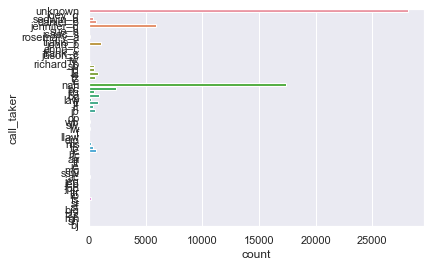

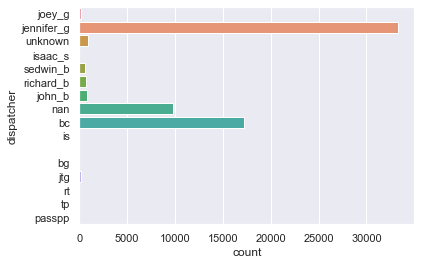

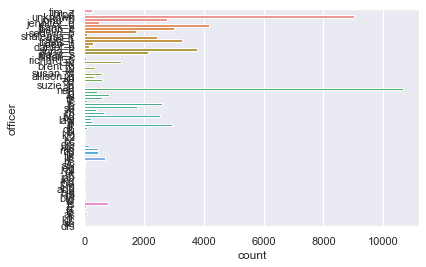

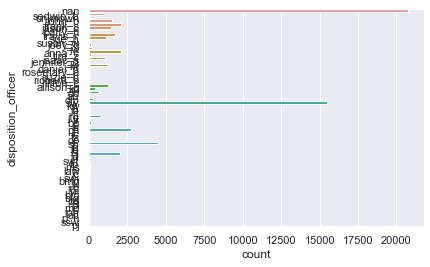

In [30]:
plot_counts(name_cols)



If I was able to consult someone of knowledge at the baton rouge animal control facility, I would be able to sort out the names better(i.e. are any of the initials representative of the given full names). I looked at the staff directory on their website but only found two names listed, and aren't present in the dataset. It was for the director and 'cat in tree complaints'.

Below, I'm iterating through name columns to see how many days each unique name shows, and how many unique names show per day:  

Basically, 
- how many employees per position do they have on staff per day* &
-  how many days has that employee worked in that role(over the span of 6 years).*

*_(If we were to assume that daily, all workers had their names on at least one report in respective column)_

In [31]:
for col in name_cols:
# df with incident time and position dropping nas
    df2 = df[['incident_date', col]].dropna().reset_index()

# grouping df by unique count of worker in position per day
# then seeing how many days they have each given number of dispatchers
    print ('\nnumber of',col,'/ number of days\n',df2.groupby('incident_date')[col].nunique().value_counts())
# how many days does each employee position appear on indicent report
#    df3 = df[['incident_date', col]].dropna().reset_index()

#    print (' employee/ number of days worked')df3.groupby(col)['incident_date'].nunique())


number of call_taker / number of days
 3     724
2     614
4     514
5     242
1     197
6     104
7      64
8      22
9      11
10      5
11      2
Name: call_taker, dtype: int64

number of dispatcher / number of days
 1    1322
2    1163
3      13
4       1
Name: dispatcher, dtype: int64

number of officer / number of days
 7     390
6     356
5     340
8     304
4     288
3     265
9     160
2     153
10    106
1      69
11     45
12     19
13      4
Name: officer, dtype: int64

number of disposition_officer / number of days
 2     770
3     397
1     246
8     216
7     212
9     161
4     153
6     144
5      85
10     83
11     26
12      4
13      2
Name: disposition_officer, dtype: int64


if the above assumption were verified, it would appear:
- most often there are 1-3 call takers on staff, almost always between 1-5
- 1 dispatcher per day, very rarely 2 or 3, or could be data entry error
- usually 3-4, or between 1 and 7 officers
- usually 2 disposition officers, or between 1 and 4

This information doesn't seem important enough to include, and is also a little messy for me to navigate without having more information on the staffing of the animal control officers and call takers.

In [32]:
df.drop(columns = name_cols, inplace=True)

#### equipment number

ID of the vehicle sent to the incident location

In [33]:
df.equipment_number.value_counts()

AC04     5555
AC12     5380
AC09     5378
AC13     4850
AC10     4409
AC06     4270
AC11     4198
AC19     4039
AC18     3386
AC01     3249
AC16     3124
AC15     2493
AC14     1466
AC20      186
19        115
12        100
15         77
AC9        77
4          73
AC6        71
11         62
10         59
13         58
14         55
09         50
AC4        49
9          41
1          37
AC05       37
16         36
         ... 
06         14
AC 19      13
04         11
AC 9       10
AC 4        9
AC08        7
AC 1        7
AC 18       6
AC 8        6
AC 13       5
AC 6        5
18          4
AC 14       4
5           3
17          3
AC 12       3
AC 20       3
AC5         2
AC-14       2
AC016       1
AC-10       1
AC-4        1
AC198       1
2692        1
ZAC14       1
SC          1
4C18        1
AC 7        1
AC 15       1
AC- 4       1
Name: equipment_number, Length: 67, dtype: int64

In [34]:
clean_str('equipment_number')

removing all non digit characters, and removing the beginning 0

In [35]:
df['equipment_number'] = remove_numpunc(df['equipment_number'], pattern ='[^0-9]+')

In [36]:
df['equipment_number'] = df['equipment_number'].apply(lambda x : x[1:] if x.startswith("0") else x)

replacing the out of bounds numbers with Nan, replacing the '4C18' value, which I have assumed was intended to be AC18. Also, replacing the values that had no digits with NaN.

In [37]:
df['equipment_number'] = df.equipment_number.replace('2692', 'nan')
df['equipment_number'] = df.equipment_number.replace('198', 'nan')
df['equipment_number'] = df.equipment_number.replace('418', '18')
df['equipment_number'] = df['equipment_number'].apply(lambda x : x.replace(x,'nan') if x=='' else x)

In [38]:
df.equipment_number.value_counts()

nan    10248
4       5699
9       5556
12      5483
13      4913
10      4484
6       4393
11      4282
19      4167
18      3397
1       3344
16      3161
15      2571
14      1528
20       189
5         42
7         35
17        28
8         13
Name: equipment_number, dtype: int64

#### impound_number

Number used to track animals being impounded into shelter.

In [39]:
df.impound_number.value_counts()

0.0        20
46757.0     2
36155.0     2
24181.0     2
42765.0     2
20866.0     2
24164.0     2
64540.0     2
58487.0     2
26043.0     2
24941.0     2
27535.0     2
41801.0     2
61184.0     2
52488.0     2
24290.0     2
30292.0     2
26970.0     2
27288.0     2
35637.0     2
24267.0     2
59758.0     2
29797.0     2
40689.0     2
20057.0     2
23447.0     2
38486.0     2
53254.0     2
63752.0     2
38399.0     2
           ..
79168.0     1
88590.0     1
81436.0     1
51477.0     1
22195.0     1
47900.0     1
79167.0     1
45034.0     1
79170.0     1
43841.0     1
91070.0     1
59834.0     1
94533.0     1
85466.0     1
57858.0     1
79713.0     1
79173.0     1
35835.0     1
59778.0     1
57993.0     1
76064.0     1
79172.0     1
76071.0     1
42459.0     1
79043.0     1
42190.0     1
90065.0     1
79171.0     1
79071.0     1
90112.0     1
Name: impound_number, Length: 43268, dtype: int64

0.0 values are being reassigned to NaN

In [40]:
# what do the 0 impound number rows look like
df[ df['impound_number'] == 0.0 ]

,incident_date,incident_time,dispatched_time,dispatched_other,dispatched_situation,arrival_time,available_time,complainant_street,request_type,equipment_number,...,zip_code,service_code,species,breed,size,color,condition,temperment,disposition,disposition_date
63860,05/03/2012,8:19,9:4,0,D,9:28,9:43,ELLIOT RD,NaN,19,...,NaN,TRAPPED ANIMAL,WILDLIFE,OTHER,MEDIUM,RED,NaN,NaN,RETURN TO WILD,05/04/2012
64630,07/17/2012,9:7,9:11,0,D,9:36,9:37,FRONTIER DR,NaN,1,...,NaN,TRAPPED ANIMAL,WILDLIFE,SQUIRREL,SMALL,NaN,FAIR,NERVOUS,RETURN TO WILD,07/17/2012
58310,08/14/2012,9:55,NaN,0,NaN,NaN,NaN,GIBBENS,NaN,nan,...,NaN,STRAY AN. SECURED,CAT,DSH,SMALL,GRY/BLK/BRWN,FAIR,NORMAL,TRANS CAA,08/15/2012
53784,10/07/2012,13:41,NaN,1,NaN,NaN,NaN,SKYSKAIL,NaN,12,...,NaN,STRAY,DOG,XDACHSHUND,MEDIUM,BRIN BLK WHT,FAIR,NERVOUS,TRANS CAA,10/08/2012
49239,12/28/2012,8:27,9:10,0,D,9:19,9:28,HAVENWOOD DR,NaN,11,...,NaN,TRAPPED ANIMAL,WILDLIFE,POSSUM,MEDIUM,WHT/GRY,FAIR,NORMAL,RETURN TO WILD,12/28/2012
35998,02/19/2013,9:56,10:21,0,D,10:34,10:44,SHERWOOD FOREST DR,NaN,6,...,NaN,TRAPPED ANIMAL,CAT,DSH,LARGE,BLK/WHT,FAIR,NERVOUS,TRANS CAA,02/19/2013
49179,05/01/2013,12:33,13:22,0,D,13:31,13:46,MADISON AV,NaN,12,...,NaN,TRAPPED ANIMAL,WILDLIFE,POSSUM,MEDIUM,GREY,FAIR,NORMAL,RETURN TO WILD,05/01/2013
38545,07/09/2013,8:36,8:54,0,D,9:18,9:47,CRESTVIEW AV,NaN,1,...,NaN,STRAY,DOG,ROTTWEILLER,MEDIUM,BLK/TAN,FAIR,NORMAL,TRANS CAA,07/10/2013
53032,08/01/2013,9:47,10:16,0,D,10:36,10:44,OAKMOUNT DR,NaN,15,...,NaN,TRAPPED ANIMAL,WILDLIFE,RACCOON,LARGE,BRN/BLK,FAIR,NORMAL,RETURN TO WILD,08/01/2013
69585,11/24/2013,18:6,NaN,0,NaN,NaN,NaN,CHERRY BARK,NaN,4,...,NaN,TRAPPED ANIMAL,WILDLIFE,POSSUM,EXTRA LARGE,GREY,FAIR,NORMAL,RETURN TO WILD,11/24/2013


Although many of these were transferred to the animal shelter, the record fails to show unique impound numbers for them.

In [41]:
# replacing '0.0' impound with NaT
df.loc[df['impound_number'] == 0.0, 'impound_number'] = np.NaN

In [42]:
#print (len(df[df.duplicated(subset=['file_number','incident_date'], keep=False)])/len(df))
df[df.duplicated(subset=['impound_number'], keep=False)]

,incident_date,incident_time,dispatched_time,dispatched_other,dispatched_situation,arrival_time,available_time,complainant_street,request_type,equipment_number,...,zip_code,service_code,species,breed,size,color,condition,temperment,disposition,disposition_date
28371,05/02/2016,06:03,08:52,0,D,09:07,09:17,AVENUE C ST,PATROL AREA,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28329,05/02/2016,06:04,09:18,0,D,09:33,09:51,TRUMAN ST,CRUELTY RECHECK,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28277,05/02/2016,06:06,08:26,0,D,08:45,08:53,CHARLES ST,PATROL AREA,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3060,05/02/2016,06:15,00:00,0,K,00:00,00:00,HUNTERS TRAIL DR,OTHER,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28255,05/02/2016,06:18,09:51,0,D,10:09,10:11,SAUL AV,CRUELTY RECHECK,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2196,05/02/2016,06:19,13:38,0,D,14:34,14:34,WILLIAMS RD,CRUELTY RECHECK,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28251,05/02/2016,06:23,08:27,0,D,08:47,08:51,PLAZA DR,CRUELTY RECHECK,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3050,05/02/2016,06:23,10:14,0,D,10:14,10:33,O'NEAL LN,DELIVERED TAGS,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3168,05/02/2016,06:24,08:39,0,D,08:45,08:48,PLANK RD,DELIVERED TAGS,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891,05/02/2016,07:28,08:28,0,D,08:58,09:10,ORLANDO DR,PICK UP TRAP,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I don't notice any rows that look similar enough to be considered duplicates. However, I don't see this feature being useful for me.

In [43]:
df.drop(columns=['impound_number'], inplace=True)

#### dispatched situation, dispatched other

- __dispatched situation:__ Indicates if officer was dispatched (D) or the call had to be postponed (K) and addressed the following day. ( _data source does not explain U,F, or N_ )


- __dispatched_other:__ Not dispatched by cad but there is dispatch info in record



In [44]:
for col in ('dispatched_situation', 'dispatched_other'):
    df[col].value_counts()

D    51144
K     4566
U      155
F        5
N        1
Name: dispatched_situation, dtype: int64

0    62337
1     1196
Name: dispatched_other, dtype: int64

In [45]:
# won't be needing these
df.drop(columns=['dispatched_situation', 'dispatched_other'], inplace=True)

### service code, request type (service_type)

Request type is the type of incident being reported, and similarly, service code is used at the responding officer's discretion. 

In [46]:
sr = ('service_code', 'request_type')

In [47]:
for col in sr:
    print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

-- Service_code --
 TRAPPED ANIMAL           16254
STRAY                     6694
STRAY AN. SECURED         3703
STRAY AN SECURED          2186
LOOSE                     2078
INJURED                   1934
OWNER SIGNED RELEASE      1441
ABANDONED ANIMAL          1235
WILD LIVE                 1222
BITE CASE LOOSE            842
SICK ANIMAL                779
UNIT STANDING BY           772
ANIMAL RESCUE              727
CRUELTY                    600
VET PICKUP                 510
BITE CASE SECURE           427
DANGEROUS ANIMAL SIT.      354
SNAKE                      335
DANGEROUS ANIMAL SIT       279
SCHOOL CALL                242
LOOSE LIVESTOCK            242
UNKNOWN                    228
SPECIAL CASE               132
BITE CASE                  106
DOG FIGHTING                13
OWNED                        4
HIT BY CAR                   1
Name: service_code, dtype: int64 

-- Request_type --
 UNKNOWN                       6405
TRAPPED ANIMAL                5737
STRAY             

In [48]:
#fixing service codes

def rename_code(word, new):
    df.loc[df['service_code'] == word, 'service_code'] = new

#stray
rename_code('STRAY AN. SECURED', 'STRAY')
rename_code('STRAY AN SECURED', 'STRAY')
#dangerous
rename_code('DANGEROUS ANIMAL SIT', 'DANGEROUS')
rename_code('DANGEROUS ANIMAL SIT.', 'DANGEROUS')
#bite
rename_code('BITE CASE LOOSE', 'BITE CASE')
rename_code('BITE CASE SECURE', 'BITE CASE')
#wildlife
rename_code('WILD LIVE', 'WILD LIFE')
#others
rename_code('UNKNOWN', np.NaN)
rename_code('OTHER', np.NaN)
#abandoned
rename_code('ABANDONED ANIMAL', 'ABANDONED')

In [49]:
# fixing request types

def rename_type(word, new):
    df.loc[df['request_type'] == word, 'request_type'] = new
#stray    
rename_type('STRAY ANIMAL SECURED', 'STRAY')
rename_type('STRAY ANIMAL', 'STRAY')
#dangerous
rename_type('DANGEROUS ANIMAL SITUATION', 'DANGEROUS')
#school
rename_type('ANIMAL ON SCHOOL CAMPUS', 'SCHOOL CALL')
#others
rename_type('UNKNOWN', np.NaN)
rename_type('OTHER', np.NaN)
#abandoned
rename_type('ABANDONED DOG', 'ABANDONED')

rename_type('CRUELTY RECHECK', 'RECHECK')

In [56]:
for col in ('service_code', 'request_type'):
    clean_str(col)
    df[col] = remove_numpunc(df[col], pattern='[^A-Za-z_]+')
    df.loc[df[col] == 'nan', col] = np.NaN

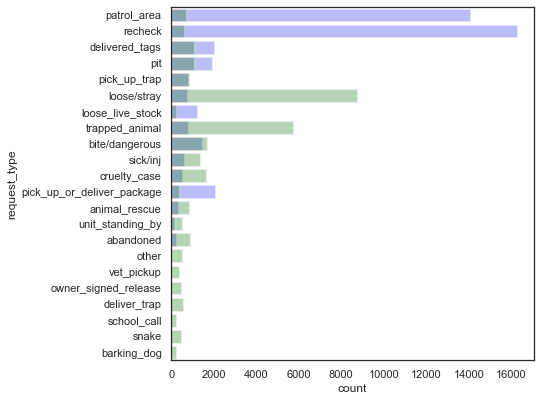

In [64]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.countplot(y='service_code', data=df, color='blue', alpha=.3)
sns.countplot(y='request_type', data=df, color='green', alpha=.3);

In [63]:
for word in ('dog_fighting', 'dangerous', 'bite_case'):
    df['service_code'] = df['service_code'].replace(word, 'bite/dangerous')
    df['request_type'] = df['request_type'].replace(word, 'bite/dangerous')
    
for word in ('issue_summons', 'in_home_signed', 'warning_notice', 'special_case', 'deliver_tags', 'trap'):
    df['service_code'] = df['service_code'].replace(word, 'other')
    df['request_type'] = df['request_type'].replace(word, 'other')
    
for word in ('loose_animal', 'loose_livestock', 'wild_life', 'stray', 'loose', 'loose_live_stock'):
    df['service_code'] = df['service_code'].replace(word, 'loose/stray')
    df['request_type'] = df['request_type'].replace(word, 'loose/stray')
    
for word in ('injured_animal', 'vet_transfer', 'sick_animal', 'injured', 'vet_pickup', 'hit_by_car'):
    df['service_code'] = df['service_code'].replace(word, 'sick/inj')
    df['request_type'] = df['request_type'].replace(word, 'sick/inj')

for word in ('cruelty', 'cruelty_case', 'abandoned', 'animal_rescue'):
    df['service_code'] = df['service_code'].replace(word, 'bite/dangerous')
    df['request_type'] = df['request_type'].replace(word, 'bite/dangerous')
    
for word in ('owned', 'owner_signed_release'):
    df['service_code'] = df['service_code'].replace(word, 'owned')
    df['request_type'] = df['request_type'].replace(word, 'owned')
    
for word in ('patrol_area', 'recheck', 'unit_standing_by'):
    df['service_code'] = df['service_code'].replace(word, 'patrol')
    df['request_type'] = df['request_type'].replace(word, 'patrol')

In [60]:
for word in ('dog_fighting', 'dangerous', 'bite_case'):
    df['service_code'] = df['service_code'].replace(word, 'bite/dangerous')
    df['request_type'] = df['request_type'].replace(word, 'bite/dangerous')

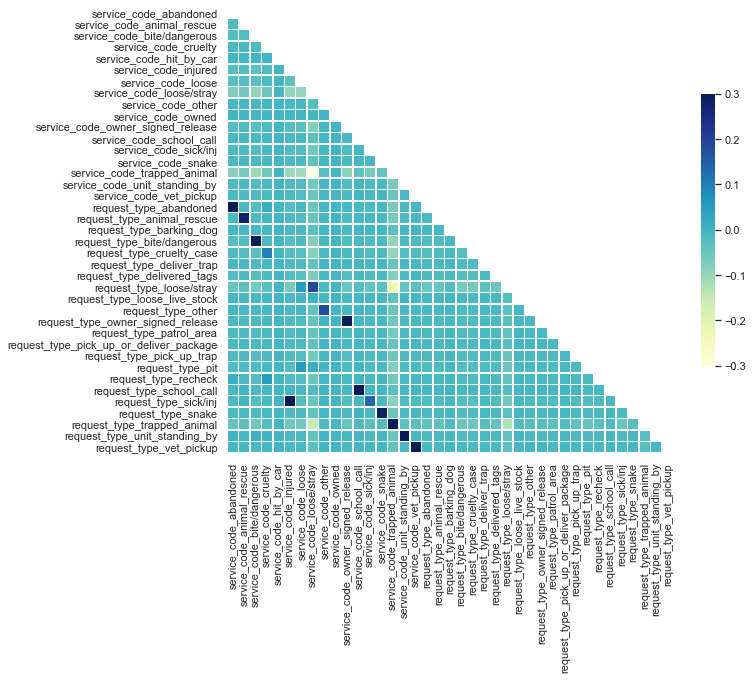

In [65]:
sr_df = df[['service_code', 'request_type']]
corr_plot(sr_df)

In [ ]:
# creating column that fills in missing values from service code using existing values from request type
df['service_type']=df['service_code'].mask(pd.isnull, df['request_type'])

# dropping merged columns
df.drop(columns=['service_code', 'request_type'], inplace=True)

In [ ]:
# removing punctuations, lower casing, etc..
clean_str('service_type')
df['service_type'] = remove_numpunc(df['service_type'], pattern='[^A-Za-z_]+')

In [ ]:
def rep_service(word, replacement):
    df['service_type'] = df['service_type'].apply(lambda x: x.replace(word, replacement))  

In [ ]:
# unifying service types

#cruelty case
rep_service('abandoned', 'cruelty_case')
rep_service('cruelty_case', 'cruelty')

# stray animals
rep_service('stray_animal_secured', 'stray_an_secured')

#loose animal and loose could include loose livestock, so I will assign all to 'loose'
rep_service('loose_animal', 'loose')
rep_service('loose_livestock', 'loose')
#rep_service('loose_animal', 'loose')

# injured - injured animal and injured dog all under injured
rep_service('pick_up_trap', 'trap')
rep_service('deliver_trap', 'trap')
rep_service('hit_by_car', 'injured')

#
rep_service('delivered_tags', 'deliver_tags')

rep_service('wild_live', 'wild_life')

rep_service('other', 'unknown')

rep_service('abandoned_dog', 'abandoned_animal')
rep_service('abandoned_animal', 'abandoned')

rep_service('animal_on_school_campus', 'school_call')

rep_service('owned', 'owner_signed_release')

In [ ]:
df.service_type.value_counts()

In [ ]:
#df.loc[df['service_type'] == 'unknown', 'service_type'] = np.NaN
df.loc[df['service_type'] == 'stray_an_secured', 'service_type'] = 'stray'

df.loc[df['service_type'] == 'bite_case_loose', 'service_type'] = 'dangerous_animal_sit'
df.loc[df['service_type'] == 'bite_case_secure', 'service_type'] = 'dangerous_animal_sit'
df.loc[df['service_type'] == 'dog fighting', 'service_type'] = 'dangerous_animal_sit'

df.loc[df['service_type'] == 'sick_animal', 'service_type'] = 'sick/injured'
df.loc[df['service_type'] == 'injured', 'service_type'] = 'sick/injured'

df.loc[df['service_type'] == 'sick_animal', 'service_type'] = 'sick/injured'


### date & time

Converting dates and times to appropriate format.


#### datetime: incident and impound

- Merging incident date and time to datetime column, repeat with impound date & time.

In [ ]:
# incident date + incident time for merged datetime column
df['inc_dt'] = pd.to_datetime(df['incident_date'].apply(str)+' '+df['incident_time'])

In [ ]:
# impound date + impound time = impound datetime
df['imp_dt'] = pd.to_datetime(df['impound_date'].apply(str)+' '+df['impound_time'], errors ='coerce')

In [ ]:
#assigning NaT to out of bounds dates and times
for col in ('inc_dt', 'imp_dt'):   
    df.loc[df[col] == datetime.time(0, 0, 0), col] = pd.NaT
    df.loc[df[col] < '2012-01-01 00:00:00 ', col] = pd.NaT

In [ ]:
df = df.sort_values(by='inc_dt')
df.reset_index(drop=True, inplace=True)

In [ ]:
df.head()

####  Time Features:

In [ ]:
# time columns to list, then loop conversion to date.time
time_cols= [col for col in df.columns if 'time' in col]

# covert time to hour/minute datetime format
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', format="%H:%M").dt.time

In [ ]:
for col in time_cols:
    df[col].value_counts().head(10)

there's consistently high counts around 8-10ish, although impound times highest look a little more 
The 00:00:00 is probably the default, not actual times, so I will replace with NaT.

In [ ]:
# replacing '00:00:00' with NaT
for col in time_cols:
    df.loc[df[col] == datetime.time(0, 0, 0), col] = pd.NaT

In [ ]:
print('Incident time Range:\n''from',df.incident_time.min(),'\n to:', df.incident_time.max())

####  Date Features:

In [ ]:
# all date columns to list
date_cols= [col for col in df.columns if 'date' in col]

In [ ]:
# covert to month/day/year datetime format
for col in date_cols:
    df[col] = pd.to_datetime(df[col],errors='coerce', format="%m/%d/%Y")

In [ ]:
for col in date_cols:
    df[col].value_counts().head()
    df[col].value_counts().tail()

In [ ]:
# date range of dataset
print('Incident Date Range:\n''from:',df.incident_date.min(),'\n to:', df.incident_date.max())

I noticed some dates were entered as older than 2012,or newer than 2019 which I assume was a mistake. 

In [ ]:
#dates out of range to NaT
for col in date_cols:
    df.loc[df[col] < '2012-01-01 00:00:00 ', col] = pd.NaT

#df.loc[df['impound_date'] < '2012-01-01 00:00:00 ']

In [ ]:
for col in date_cols:
    df.loc[df[col] > '2019-10-04 00:00:00 ', col] = pd.NaT

#### additional time features:

___
Below, I will be:


- Creating feature representing time difference between incident time and impound time.  

*_The incident date&time is when the incident was called in, the impound time is when the animal was brought to the shelter. It's possible that not every incident called in resulted in an impound, which may be the reason values are missing from impound._


__difference between datetime of incident call and impound datetime__

In [ ]:
## time difference from incident to impound
#df['inc_to_imp'] = df['imp_dt']-df['inc_dt']

In [ ]:
for col in ('inc_dt', 'imp_dt'):   
    df.loc[df[col] == datetime.time(0, 0, 0), col] = pd.NaT
    df.loc[df[col] < '2012-01-01 00:00:00 ', col] = pd.NaT

___
Weekday and Month:

This may not provide anything insightful, but I'm creating columns for weekday and month of incident.

__- Weekday Feature-__

In [ ]:
# creating day of week column:
df['weekday'] = pd.to_datetime(df['impound_date']).apply(lambda x: x.weekday())

df.weekday.value_counts()
# 0= monday

It looks like most incidents occur on Mondays, and then dwindle down throughout the week, with much less incidents reported on weekends

Are the amount of impounds per day relative to the amount of incidents?

In [ ]:
# how does incident day of week compare to impound day of week?:
imp_weekday_counts=(pd.to_datetime(df['incident_date'].dropna()).apply(lambda x: x.weekday()).value_counts())
(imp_weekday_counts.sum())/(df.weekday.value_counts().sum())
imp_weekday_counts/df.weekday.value_counts()
# 0= monday

Something seems strange here. The dataframe has 76% of total not-null impounds to total incidents, why would there be 30% more impounds than incidents on any of the days, especially weekends?

___
__- Month feature-__

In [ ]:
# column for month
df['month'] = pd.DatetimeIndex(df['impound_date']).month

df.month.value_counts()

__Warmer Climate = More Animal Control Incidents?__  _*unsurpisingly_

May-September appear to have the most incidents. According to weather.com, the average temperature increases rises from the 50's to 60's degree Fahrenheit around min April, and then begins to dip below the 60s again towards the end of October(although Baton Rouge typically experiences the most volume in rainfall in June and August). Using that information, you can infer a positive correlation between weather and incidents, similar to the common correlation with temperature and crime. This isn't a real shocker, just an observation confirming what one might already assume.

*_Note that since the dates run between Jan-1-2012 to Oct-3rd-2019, there will be bias towards the first 10 months._

In [ ]:
for col in ('month', 'weekday'):
    df[col] = df[col].astype(str)

### animal features

Animals features include __color__, __breed__, __condition__, __temperment__, and __size__. color and breed present an issue with such high unique values for what should be considered , multiple spellings for the same color/breed, and alternate sequences of the same substrings appearing as different values( i.e. brown/white vs white/brown)

#### color

##### unifying spellings of colors

In [ ]:
#df.color.value_counts()
df.color.value_counts()

Color Feature Cleaning:

- Not liking the all caps, also unnecessary punctuation.


- 1089 unique color values is going to be a problem for machine learning models, so I'd also like to reduce those. Each color needs to have uniform spelling, and combinations with low value counts will be categorized as 'other' to reduce dimensionality and noise.

*_I'll be treating each combination as it's own category. I'm not sure if approaching each color as a separate feature would be practical, but maybe could be given more thought later. I don't see value in each individual color as much as the overall description of color(s) as a whole._

In [ ]:
pre_color = df.copy()

In [ ]:
df= pre_color.copy()

In [ ]:
clean_str('color')

In [ ]:
df['color'] = remove_numpunc(df.color, pattern = '[^A-Za-z,]+')

By looking at value counts of strings, I can decide which ones need uniform spelling. The ones with higher counts will be prioritized, and some may slip through the cracks, as it is a tedious task. Colors with strong similarity will be placed into major color categories as well, at my discretion.(ie. tan, sandy, and blonde all identified as 'tan') 

##### editting color names

In [ ]:
# white: wht
whites = ('white', 'cream', 'whute', 'whit', 'whitg', 'wht','whtie'
          , 'wwht', 'what','wt','whitge','whiite','whute','shite')

edit_replace(whites, 'wht')

# blacks: bl
blacks = ('black', 'blk', 'blkl', 'charcoal', 'bllk', 'balck', 'blavk', 'bkl', 'vlack'
          , 'blavck', 'blkc', 'blakc')

edit_replace(blacks, 'bk')

# browns: br
browns = ('brown','brrwn', 'brwn', 'brn', 'choc', 'chocolate', 'brwon', 'choclate'
          , 'brw', 'brownish', 'brow', 'brnlate', 'brnish', 'brnolate', 'brnm', 'brolate'
          , 'brblk','chestnut', 'cho', 'brrwn', 'bbrown','bown')

edit_replace(browns,'br')

# greys: gry
greys = ('grey', 'gray', 'grrey','greymarble')

edit_replace(greys, 'gry')

# tans/beige/blonde: tn
tans = ('beige', 'blonde', 'golden', 'tan\\', 'goldish', 'tna', 'gold', 'tan', 'taan', 'sandy')

edit_replace(tans, 'tn')

# stripes: stripe_tabby
tabbies = ('tabby','tiger', 'tabble', 'taddy', 'tabs', 'tabbie')

edit_replace(tabbies, 'tab')

# calico = cal
edit_replace(('calico','claico'), 'cal')

# orange: or
oranges = ('orange', 'orn', 'copper', 'orang', 'orage', 'ornage')

edit_replace(oranges, 'org')

# brindle/fawn: brndl
brindles = ('brindle', 'fawn', 'merle', 'torti', 'marbled', 'tortie', 'bridle', 'brndl', 'brndle', 'brndlee','leopard', 'tortoise', 'brindlw', 'brindlde')

edit_replace(brindles, 'bndle')

# yellow: yel
edit_replace(('yellow','yelow','yellw', 'yell', 'ylw'), 'yel')

# stop words and not decribing color (* is there a better way to do this?)
to_drop = ('chest','and', 'normal', 'nose', 'paws', 'mouth', 'with', 'tail'
           , 'belly', 'head', 'ears', 'eyes', 'face', 'feet', 'color', 'standard',
          'fred', 'pattern', 'newbord', 'mostly', 'front', 'all', 'body', 'little', ' ', '  ')

edit_replace(to_drop, '')

##### alphabetizing and 'other' feature for low value counts

In [ ]:
df['color'] = [','.join(sorted(i.split(','))) for i in df['color']]

df['color'] = df['color'].apply(lambda x : x[1:] if x.startswith(",") else x)

In [ ]:
# defining counts to separate at 20 value counts
counts = df['color'].value_counts()

# color combinations with less than 20 counts will be categorized as 'other'
other_color_df =df[df['color'].isin(counts[counts < 10].index)]

other_color_df['color'] = 'other'

#should be one value: 'other'
other_color_df.color.value_counts()

In [ ]:
# color values with over/equal to n counts
colors_df =df[df['color'].isin(counts[counts >= 10].index)]

#should be n or more per value
colors_df.color.value_counts().tail()

In [ ]:
#joining the 'other color' and 'all colors' dfs
df = pd.concat([colors_df,other_color_df ])

In [ ]:
# # replacing unknown values
df.loc[df['color'] == 'nan', 'color'] = np.NaN
#df.loc[df['color'] == 'other', 'color'] = np.NaN
df.loc[df['color'] == 'unknown', 'color'] = np.NaN
df.loc[df['color'] == '', 'color'] = np.NaN
df.loc[df['color'] == 'tn,tn', 'color']='tn'
df.loc[df['color'] == 'wht,wht', 'color'] = 'wht'

In [ ]:
#all should have a minimum n value counts, 'other' should now be included
df.color.value_counts().head(90)

#### breed

In [ ]:
df.breed.value_counts()


*_DSH=Domestic Short Hair, DMH= Domestic Medium Hair, and DLH=Domestic Long Hair_

In [ ]:
# remving X from beginnings
df['breed'] = df['breed'].apply(lambda x : x[1:] if str(x).startswith("X") else x)
# lower casing and '_'
clean_str('breed')
# removing extra '_'s
df['breed'] = df.breed.apply(lambda x: x.replace('__', '_'))
# removing other punctuation
df['breed'] = remove_numpunc(df['breed'], pattern='[^A-Za-z_]+')

*_some of these breeds sound very similar(ie. staffordshire bull terrier vs american staffordshire terrier, doberman vs doberman pinscher, but I have investigated the questionably similar breeds before reassigning to the same variable._

In [ ]:
def rep_breed(word, replacement):
    df['breed'] = df['breed'].apply(lambda x: x.replace(word, replacement)) 

In [ ]:
# replacing breed names 
rep_breed('chow_chow', 'chow')
rep_breed('boston_terrier', 'boston')
rep_breed('poodle_standard', 'poodle')
rep_breed('basset_hound', 'basset')
rep_breed('rottweiller', 'rott')
rep_breed('rottweiler', 'rott')
rep_breed('pit_bull', 'pitbull')
rep_breed('pitbull', 'pit')
rep_breed('labrador_retriever', 'labrador')
rep_breed('catahoula_hound', 'catahoula')
rep_breed('english_bulldog', 'bulldog_english')
rep_breed('shar_pei', 'sharpei')
rep_breed('brittany_spaniel', 'brittany')
rep_breed('other', 'unknown')

In [ ]:
df.loc[df['breed'] == 'nan', 'breed'] = np.NaN

In [ ]:
#len(df.breed.value_counts())
df.breed.value_counts()

#### condition, disposition, size, species, temperment

In [ ]:
cdsst ='species', 'size', 'condition', 'temperment', 'disposition'

In [ ]:
for col in cdsst:
    clean_str(col)
    df[col] = remove_numpunc(df[col], pattern='[^A-Za-z_]+')

In [ ]:
for col in cdsst:
    df.loc[df[col] == 'nan', col] = np.NaN
    df.loc[df[col] == 'unknown', col] = np.NaN

In [ ]:
for col in cdsst:
    print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

In [ ]:
df["species"]=df['species'].replace("birds", "bird")

In [ ]:
df["temperment"]=df['temperment'].replace("nan", np.NaN)
df["temperment"]=df['temperment'].replace("unknown", np.NaN)

#there's only 24 'scared' cases, and is similar enough to be interpreted as 'nervous'
# ideally I would consult with the animal control facility on how they make assign the temperment
df["temperment"]= df['temperment'].replace("scared", 'nervous')

I'm assigning 'return to owner', and 'return to wild' to the same variable, as they're both indicators that the incident resulted in the most ideal of the outcomes

In [ ]:
# return to wild and return to owner to the same 'return to wild/owner'
df['disposition'] = df['disposition'].replace('return_to_wild', 'return_to_wild/owner')
df['disposition'] = df['disposition'].replace('return_to_owner', 'return_to_wild/owner')

### location related

The features describing location are: municipality, location, zip code, and complainant street.

The only column without missing values is the street feature. The usefulness of this feature in analysis is questionable, but if enough correlation exists, I could use it to fill in missing data in one of the other features with the most likely value.

In [ ]:
loc_cols = ('municipality', 'location', 'zip_code', 'complainant_street')

In [ ]:
for col in loc_cols:
    df[col].isna().sum()/len(df)

In [ ]:
for col in loc_cols:
    clean_str(col)

Since I've lower cased everything, I now have to fix the 'nan's. I think there probably is a better way to do it without having to go back and do this, but for now I'm going with it

In [ ]:
# since I've lower cased everything, now I have to fix the 'nan's
df.loc[df['zip_code'] == 'nan', 'zip_code'] = np.NaN
df.loc[df['complainant_street'] == 'nan', 'complainant_street'] = np.NaN
df.loc[df['location'] == 'nan', 'location'] = np.NaN

# there seems to be a lot of 'unknown' values in the dataset, it could make things noisy
df.loc[df['zip_code'] == '', 'zip_code'] = np.NaN
df.loc[df['municipality'] == 'unknown', 'municipality'] = np.NaN

In [ ]:
for col in loc_cols:
    print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

Interesting that there are so many incidents occurring at some of these unique addresses. I'm wondering if this is a case of duplicate rows.


*_After researching, I found this from the ACRC website:
...However, location data regarding where the incident was reported or occurred is included within this data set, which may or may not be the same location as the animal owner's home or property._

In [ ]:
# df[df['location'] == '2680_progress']

Just out of curiousity, how many locations have more than 50 recorded incidents?

In [ ]:
# dups = location with above threshold value counts/duplicates
# how many place
dups = df.groupby('location').filter(lambda x: x.location.value_counts().max() > 50)
dups.location.value_counts()

complainant street has no nas, but not sure if it provides value to analysis without a region

# __Explore__

### datetime features

#### times

There are 5 different time categories. Their descriptions are self descriptive, although the 'available time' wasn't clear at first. That category marks the time that the responding officer was finished with the incident and once again available.

In [ ]:
for col in time_cols:
    plot_dtcount(df, col, overlap = False, labels = time_cols)

In [ ]:
# plotting frequency of each time feature:
f, ax = plt.subplots(figsize=(8, 6.5))
for col in time_cols:
    plot_dtcount(df, col
                 , (0, 600)
                 , labels = time_cols)

Around 9am-ish the incident count reaches a peak, then once again rises between 12pm-4pm, 

#### dates

In [ ]:
for col in date_cols:
    plot_dtcount(df, col, overlap = False, labels = date_cols)

Why does the disposition date and slightly with impound date, is there a decline in incidents?
It's possible that measures have been taken over time to reduce the amount of impounds, but with the disposition date, I'm wondering if the animal control facility just hasn't been consistently filling out that part of the record in the past couple of years.

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
for col in date_cols:
    plot_dtcount(df, col, overlap = True, labels = date_cols, alpha=.5, size=12)

I would have expected the disposition date, incident date, and impound date, to have a more positive, collinear relationship throughout the full 8 years of the data, it's strange that after 2016, there's much more irregularities. The frequency of incident date is so elevated between 2016-1018. Is this an issue of data management or is there some other reason for this anomoly? I'm questioning the reliability of the the date data.

### * animal features -*  UNFINISHED

#### condition, disposition, size, species, temperment

In [ ]:
#value counts of species, size, condition, and temperment features
ssct_df = df[['species', 'size', 'condition', 'temperment', 'disposition']]

In [ ]:
plot_counts(ssct_df)

In [ ]:
# correlations between species, size, condition, and temperment
corr_plot(ssct_df, minv=-.5, maxv=.5)

# __Modeling__

### functions

In [ ]:
def chi_feats():
# using chi2 to look at feature importance
    bestfeatures = SelectKBest(score_func=chi2, k=10)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = (pd.concat([dfcolumns,dfscores],axis=1, ignore_index=True))
    featureScores.columns = ['Feats','Score']
    feat_scores=pd.DataFrame(featureScores.nlargest(25,'Score'))
    print(feat_scores.to_string(index=False))
    #print(featureScores.nlargest(25,'Score'))

In [ ]:
def xtree_feats():
    # extraTrees classifier feature importance
    # using extratrees to look at feature importance
    model = ExtraTreesClassifier();
    model.fit(X,y);
    #print(model.feature_importances_) 
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(25).plot(kind='barh');
    plt.show();

In [ ]:
def model_report(model): 
    
    print('\nCross Validation Scoring:\n')
    
    train_score = model.score(X_train, y_train)
    print("train score: {:.4}%".format(train_score * 100))

    test_score = model.score(X_test, y_test)
    print("test score: {:.4}%".format(test_score * 100))

    cv_score = np.mean(cross_val_score(model, X, y, cv=3))
    print("cross val score: {:.4}%".format(cv_score * 100))
    
    print("\nClassification Report:")
    print(classification_report(actuals, predictions))
    
    print('\nConfusion matrix:'.format(accuracy_score))
    display(pd.DataFrame(confusion_matrix(y_test, predictions)
                         ,columns=['pred trans','pred to wild', 'pred to owner', 'pred spec_case', 'pred euth/doa']
                         , index=['real trans', 'real to wild', 'real to owner', 'real spec_case', 'real_euth/doa']
                        ))

In [ ]:
# plotting feature importances
def plot_feats(model):
    n_features = X.shape[1]
    plt.figure(figsize=(8,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), (X.columns.values)) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [ ]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()


## data prep

Saving df as df1, so I can return and reselect features and target if I wish to later.
I'm also saving the train data as X_train_d and y_train_d, so I can reassign using resampling methods

In [ ]:
# cleaned data saved to copy
df1 = df.copy()

In [ ]:
list(df1.columns)

Df with disposition as target

In [ ]:
df= df[['species', 'breed', 'size', 'color', 'condition', 'temperment', 'weekday', 'month'
       ,'service_type', 'disposition', 'municipality']]

In [ ]:
#prep_mod_data(df, 'disposition')

In [ ]:
df= df.replace("nan", np.NaN)
df= df.replace('', np.NaN)
df.dropna(axis=0, inplace=True)
df = df.astype(object)

In [ ]:
df.head()

In [ ]:
df.to_csv('a_control.csv',index=False)

In [ ]:
stop

### assigning X and y, train test split

In [ ]:
# # assign target accident severity
y = df["disposition"]

#remove target from features
df.drop(columns= ['disposition'], axis=1, inplace=True)

# dummy categorical features
col_list = list(df.select_dtypes(include=['object']).columns)

# create dummies for categorical features, assign to X
df = pd.DataFrame(pd.get_dummies(data=df,columns=col_list
                           , drop_first=True
                   , prefix=col_list))
X = df

# X_train_d and y_train_d = using original standard test train spit dad
# that way, I can try out a few different resampling methods
X_train_d, X_test, y_train_d, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=3)

### feature importances

In [ ]:
# chi_feats()

In [ ]:
# xtree_feats()

## random forest

### using SMOTE

with such imbalance in the amount of data in the classes, compensating for the lack of minority data by resampling could help the model perform with more accuracy and less bias to the majority classes.

#### resampling

In [ ]:
# create the  object with the desired sampling strategy. 
smote = SMOTE(
    #sampling_strategy='minority'
)

# fit the object to our training data
X_train, y_train = smote.fit_sample(X_train_d, y_train_d)

RUS = RandomUnderSampler()
X_train, y_train = RUS.fit_sample(x_train, y_train)

In [ ]:
pipe_rf = Pipeline([('rf_model', RandomForestClassifier(random_state=3))])

#### base model

In [ ]:
#initialize and fit random forest
rf_model = RandomForestClassifier(random_state=3)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
actuals = y_test

model_report(rf_model)

the model using default parameters overfits, which is one of the common concerns with this kind of resampling. The majority classes(transfered to shelter and released to wild) are now being predicted as the minority class.

#### random grid

In [ ]:
#print(rf_model)

In [ ]:
# set random search params
bootstrap = [True, False]
criterion = ['entropy', 'gini']
max_depth = [ None]
max_depth.append(None)
max_features = ['auto']
max_leaf_nodes = [None]
max_samples = [None, 19, 20,21]
min_impurity_decrease = [None, 0.1, 0.001]
min_impurity_split = [None, 0.1, 0.001]
min_samples_leaf = [None, 19,20,21]
min_samples_split = [None,3,4,5,6]
min_weight_fraction_leaf=[ .01, .1,None]
n_estimators = [700, 900, 1000]

# Create the random grid
random_grid = { 'bootstrap': bootstrap
              , 'criterion': criterion
              , 'max_depth': max_depth
              , 'max_features': max_features
              , 'max_leaf_nodes': max_leaf_nodes
               , 'max_samples': max_samples
              , 'min_impurity_decrease': min_impurity_decrease
               , 'min_impurity_split': min_impurity_split
              , 'min_samples_leaf': min_samples_leaf
              , 'min_samples_split': min_samples_split
               , 'min_weight_fraction_leaf': min_weight_fraction_leaf
               , 'n_estimators': n_estimators
              }
#pprint(random_grid)

In [ ]:
# fit and search random param combinations
rf_random = RandomizedSearchCV(estimator = rf_model
                               , param_distributions = random_grid
                               , n_iter = 300
                               , cv = 5
                               , verbose=2
                               , random_state=3
                               , n_jobs = -1);
# Fit the random search model
rf_random.fit(X_train, y_train);

#### grid search

In [ ]:
rf_random.best_params_

In [ ]:
## grid search params
param_grid_rf = [
    {
    'rf_model__n_estimators': [1000, 1500],
   #     'rf_model__min_weight_fraction_leaf':[0.01],
 #   'rf_model__min_samples_split': [4,5],
        'rf_model__min_samples_leaf': [18,19],
        'rf_model__min_impurity_split': [None],
 #    'rf_model__min_impurity_decrease': [0.0001, 0.001],   
        'rf_model__max_samples':[20,22],
        'rf_model__max_leaf_nodes':[None],
     'rf_model__max_features':['auto'],
    'rf_model__max_depth': [None],
        'rf_model__criterion': ['entropy'],
     'rf_model__bootstrap':[False]
    }
]

# grid search
gs_rf = GridSearchCV(estimator=pipe_rf
                    ,param_grid=param_grid_rf
#                    ,scoring='accuracy'
                    ,cv=3
                     ,refit=True
                     ,error_score=0
                     , n_jobs=-1
                     , verbose=3
                    )

# fitting grid search
gs_rf.fit(X_train, y_train);

# best parameters
print('best accuracy: {:.4}%'.format(gs_rf.best_score_ * 100));
print('params:\n', gs_rf.best_params_);

__fitting best model__

In [ ]:
# fitting model using best params
rf_gs_model = RandomForestClassifier(
                                    bootstrap= False
                                     ,criterion= 'entropy'
                                    , max_depth= None
                                     ,max_features = 'auto'
                                    ,max_leaf_nodes = None
                                    , max_samples = 20
                                    , min_impurity_decrease = 0.0
                                    ,min_impurity_split = None
                                     ,min_samples_leaf = 18
                                     , min_samples_split = None
                                     , n_estimators = 1000
                                    );
rf_gs_model.fit(X_train, y_train);

predictions = rf_gs_model.predict(X_test);
actuals = y_test

#### best model

In [ ]:
# new model report
model_report(rf_gs_model)

Not looing good. 

In [ ]:
#plot_feats(rf_gs_model)

### using  ADASYN resampling

#### resampling

This kind of resampling oversamples the classes that are more difficult to learn. It is meant to have a similar effect as with SMOTE, and I'm hoping using the 'minority' parameter will result in a better performing model. It can help in highly imbalanced datasets, but tends to overfit.

In [ ]:
# create the object to resample the majority class.
adasyn = ADASYN()

# fit the object to the training data.
X_train, y_train = adasyn.fit_sample(X_train_d, y_train_d)


In [ ]:
pipe_rf = Pipeline([('rf_model', RandomForestClassifier(random_state=3))])

#### base model

In [ ]:
#initialize and fit random forest
rf_model = RandomForestClassifier(random_state=3)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
actuals = y_test

model_report(rf_model)

#### random grid

In [ ]:
#print(rf_model)

In [ ]:
# set random search params
bootstrap = [True, False]
criterion = ['entropy', 'gini']
max_depth = [int(x) for x in np.linspace(1, 10, num = 1)]
max_depth.append(None)
max_features = ['auto', 'sqrt']
max_leaf_nodes = [None, 1,3,10,20]
max_samples = [None, 4, 20, 100,400]
min_impurity_decrease = [0.0, 0.1, 0.2]
min_impurity_split = [None, 0.1, 0.001]
min_samples_leaf = [.01,1, 0.001]
min_samples_split = [0.1,3,5,7]
#min_weight_fraction_leaf=[0.0]
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 5)]

# Create the random grid
random_grid = { 'bootstrap': bootstrap
              , 'criterion': criterion
              , 'max_depth': max_depth
              , 'max_features': max_features
              , 'max_leaf_nodes': max_leaf_nodes
               , 'max_samples': max_samples
              , 'min_impurity_decrease': min_impurity_decrease
               , 'min_impurity_split': min_impurity_split
              , 'min_samples_leaf': min_samples_leaf
              , 'min_samples_split': min_samples_split
               , 'n_estimators': n_estimators
              }
#pprint(random_grid)

In [ ]:
# fit and search random param combinations
rf_random = RandomizedSearchCV(estimator = rf_model
                               , param_distributions = random_grid
                               , n_iter = 50
                               , cv = 3
                               , verbose=2
                               , random_state=3
                               , n_jobs = -1);
# Fit the random search model
rf_random.fit(X_train, y_train);

#### grid search

In [ ]:
rf_random.best_params_

In [ ]:
## grid search params
param_grid_rf = [
    {
    'rf_model__n_estimators': [900,1000, 1100],
        'rf_model__min_weight_fraction_leaf': [0.01,0.001],
    'rf_model__min_samples_split': [3,4],
        'rf_model__min_samples_leaf': [19],
        'rf_model__min_impurity_split': [None],
     'rf_model__min_impurity_decrease': [0.001],   
        'rf_model__max_samples':[20],
        'rf_model__max_leaf_nodes':[None],
     'rf_model__max_features':['auto'],
    'rf_model__max_depth': [None],
        'rf_model__criterion': ['gini', 'entropy'],
     'rf_model__bootstrap':[False]
    }
]

# grid search
gs_rf = GridSearchCV(estimator=pipe_rf
                    ,param_grid=param_grid_rf
#                    ,scoring='accuracy'
                    ,cv=3
                     ,refit=True
                     ,error_score=0
                     , n_jobs=-1
                     , verbose=3
                    )

# fitting grid search
gs_rf.fit(X_train, y_train);

# best parameters
print('best accuracy: {:.4}%'.format(gs_rf.best_score_ * 100));
print('params:\n', gs_rf.best_params_);

In [ ]:
# fitting model using best params
rf_gs_model = RandomForestClassifier(
                                    bootstrap= False
                                     ,criterion= 'gini'
                                    , max_depth= None
                                     ,max_features = 'auto'
                                    ,max_leaf_nodes = 21
                                    , max_samples = None
                                    , min_impurity_decrease = 0.0
                                    ,min_impurity_split = 0.1
                                     ,min_samples_leaf = 1
                                     , min_samples_split = 3
                                     , n_estimators = 500
                                    );
rf_gs_model.fit(X_train, y_train);

predictions = rf_gs_model.predict(X_test);
actuals = y_test

#### best model

In [ ]:
# new model report
model_report(rf_gs_model)

In [ ]:
#plot_feats(rf_gs_model)

That did not turn out ideally. 

## smote & undersampling

In [ ]:
pipe_rf = Pipeline([steps,('rf_model', RandomForestClassifier(random_state=3))])

## with keras

In [ ]:
from keras.models import Sequential 
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
from sklearn import preprocessing, model_selection
import keras
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

In [ ]:
X = np.array(X)
encoder = LabelEncoder()
encoder.fit(y)
Y = encoder.transform(y)
Y = np_utils.to_categorical(Y)

In [ ]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(X,Y,test_size = 0.1, random_state = 0)

In [ ]:
input_dim = len(df.columns)
model = Sequential()
model.add(Dense(8, input_dim = input_dim , activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(6, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

model.fit(train_x, train_y, epochs = 10, batch_size = 2)

scores = model.evaluate(test_x, test_y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
from sklearn.datasets import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from matplotlib import pyplot
from numpy import where
# generate 2d classification dataset
#X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 500
#trainX, testX = X[:n_train, :], X[n_train:, :]
#trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(50, input_dim=272, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(3, activation='softmax'))
# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10,batch_size=2, verbose=0)
# evaluate the model-
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
scores

____

## IGNORE- inconclusive: fbprophet

I was starting to look at possible trends in incident fre

In [ ]:
#stop

In [ ]:
# imports for fbprophet
import fbprophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_plotly, plot_yearly, plot_cross_validation_metric
import plotly.offline as py
py.init_notebook_mode()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
def fb_proph(time_data, periods=36):
    global m
    global future
    global forecast
    m = fbprophet.Prophet(interval_width=0.95
                          ,yearly_seasonality=True
                          , seasonality_mode='multiplicative'
                         )
    m.fit(time_data.reset_index())
    future = m.make_future_dataframe(periods=periods, freq='M')
    forecast = m.predict(future)
    display(plot_plotly(m, forecast, xlabel = 'Date', ylabel = 'incidents'))
    #display((forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail().round()))
    global preds
    preds = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(23)

In [ ]:
#clean_df
imp_df = df1[['impound_date', 'service_type']]
imp_df.head(20)

In [ ]:
dang_df = imp_df.loc[imp_df['service_type'] == 'stray']

In [ ]:
time_c = pd.DataFrame(dang_df.groupby(['impound_date'])['service_type'].count())

In [ ]:
time_c.index = pd.to_datetime(time_c.index,errors='coerce', format="%m/%Y")

In [ ]:
time_c.info()

In [ ]:
time_c.index.names = ['ds']
time_c.columns = ['y']

In [ ]:
time_c.head()

In [ ]:
fb_proph(time_c, periods=36)

In [ ]:
# get mape score for fbprophet and plot 
def proph_metrics(m, num_days= '1095 days'):
    
    df_cv = cross_validation(m
                             , horizon = num_days
                            )
    #df_cv.head()
    df_p = performance_metrics(df_cv)
    #df_p.tail()
    fig = plot_cross_validation_metric(df_cv
                                       , metric='mape'
                                      )
    #print(mean_absolute_percentage_error(df_cv.y, df_cv.yhat))
    #display(df_p.tail(1))
    #display(df_p.iloc[-12])

In [ ]:
#plot predicted return if property bought at current value using predictions from fbProphet
def pred_return(cur_val, preds):
    preds.set_index('ds', inplace = True)
    preds['return'] = preds['yhat'] - cur_val
    preds['lower'] = preds['yhat_lower']- cur_val
    preds['upper'] = preds['yhat_upper']- cur_val
    preds.iloc[:, 3:].plot();
    
   # plt.plot(preds)
    plt.plot(preds.iloc[:, 3:])
    plt.fill_between(
        preds.index, 
                 preds['upper'], 
                 preds['lower'], 
                 color='k', alpha=.15)

    plt.title("predicted return")
   # plt.show()